# Previsão de Tarifas em Corridas de Táxi

- Empresas  como a Uber estão usando amplamente o aprendizado de máquina para prever tarifas, tráfego e viagens usando dados anteriores.

## 1. Problema de Negócio

- Imagine que você trabalha para uma empresa de táxi e que uma das maiores reclamações de seus clientes é que eles não sabem quanto custará uma corrida até que ela termine.Isso porque a distância é apenas um dos vários fatores a partir dos quais as tarifas de táxi são calculadas.


- Você decide fazer algo a respeito criando um aplicativo móvel que os clientes possam usar quando entrarem em um táxi para estimar qual será a tarifa.Para fornecer inteligência ao aplicativo, você pretende usar as enormes quantidades de dados de tarifas que a empresa coletou ao longo dos anos para criar um modelo de aprendizado de máquina.


- O conjunto de dados contém cerca de 150000 linhas e é um subconjunto de um conjunto de dados muito maior usado na competição [New York City Taxi Fare Prediction](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction) da Kaggle.


As seguintes variáveis estão presentes no conjunto de dados:

ID
- key: deve ser usado apenas como um campo de ID exclusivo.

Target
- fare_amount: valor em dólares do custo da corrida de táxi.

Features
- pickup_datetime: data/hora que indica quando a corrida de táxi começou.
- pickup_longitude: coordenada de longitude de onde a corrida de táxi começou.
- pickup_longitude: coordenada de latitude de onde a corrida de táxi começou.
- dropoff_longitude: coordenada de longitude de onde a corrida de táxi terminou.
- dropoff_latitude: coordenada de latitude de onde a corrida de táxi terminou.
- passenger_count: número de passageiros na corrida de táxi.

## 2. Importar bibliotecas e conjunto de dados


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
 
df = pd.read_csv('taxi_tarifas.csv')
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


### 2.1 Análises preliminares

In [2]:
# Obter uma descrição dos dados

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                150000 non-null  object 
 1   fare_amount        150000 non-null  float64
 2   pickup_datetime    150000 non-null  object 
 3   pickup_longitude   150000 non-null  float64
 4   pickup_latitude    150000 non-null  float64
 5   dropoff_longitude  149999 non-null  float64
 6   dropoff_latitude   149999 non-null  float64
 7   passenger_count    150000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 9.2+ MB


 - 8 variáveis e 150000 observações no dataset e a variável fare_amount é a variável alvo. A variable dropoff_longitude e dropoff_latitude tem missing values. A variable pickup_datetime precisa ser convertida em um objeto datetime.

In [3]:
# Resumo dos atributos numéricos

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fare_amount,150000.0,11.361849,9.870671,-44.900000,6.000000,8.500000,12.500000,500.000000
pickup_longitude,150000.0,-72.500714,10.586363,-736.550000,-73.992028,-73.981732,-73.966989,40.787575
pickup_latitude,150000.0,39.921610,6.131464,-74.007670,40.734955,40.752720,40.767145,401.083332
dropoff_longitude,149999.0,-72.507088,10.406313,-84.654241,-73.991258,-73.980042,-73.963473,40.851027
dropoff_latitude,149999.0,39.928809,6.110042,-74.015160,40.734126,40.753243,40.768088,404.616667
passenger_count,150000.0,1.680407,1.305797,0.000000,1.000000,1.000000,2.000000,6.000000


- A variável de interesse fare_amount apresenta outliers.
- A variável "passenger_count" possui observações com zero passageiros, é recomendável remover essas instâncias.

In [4]:
# Analisar  a influência das variáveis de entrada, como latitude e longitude, nos valores da variable alvo fare_amount.

corr_matrix = df.corr()
corr_matrix['fare_amount'].sort_values(ascending=False)

fare_amount          1.000000
passenger_count      0.013923
pickup_longitude     0.011414
dropoff_longitude    0.009355
dropoff_latitude    -0.008716
pickup_latitude     -0.011092
Name: fare_amount, dtype: float64

- Latitudes e longitudes têm pouco a ver com a variável fare_amount pelo menos em sua forma atual, porém, eles especificam pontos de partida e chegada e passeios mais longos incorrem em tarifas mais altas.
- É necessário calcular as distâncias com base nas coordenadas de latitude e longitude fornecidas.

## 3. Pré-processamento 

### 3.1 Descarte de variáveis não importantes e conversão da variável pickup_datetime para datetime

In [5]:
df = df.drop(['key'], axis=1)

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


### 3.2 Remoção das linhas com zero passageiros

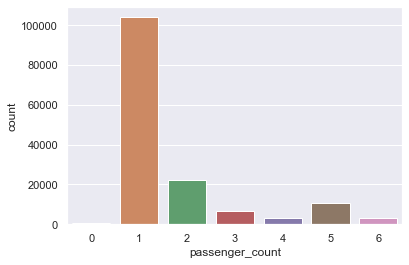

In [6]:
sns.set()

sns.countplot(x=df['passenger_count']);

In [7]:
df = df[df['passenger_count'] >= 1]

df.shape

(149447, 7)

###  3.3 Criando novas colunas de dados a partir das informações contidas em outras colunas

- dia: Dia da semana (0=segunda-feira, 1=terça-feira e assim por diante).


- hora: Hora do dia em que o passageiro foi pego (0–23 horas).


- distancia: A distância (pelo ar, não na rua) em milhas percorridas pelo passeio.Para calcular distâncias, este código assume que a maioria dos passeios são curtos e que, portanto, é seguro ignorar a curvatura do Terra.


- Um grau de latitude equivale a aproximadamente 69 milhas e um grau de longitude é igual 54,6 milhas (é possível calcular distância usando a fórmula de haversine).

In [8]:
import datetime
from math import sqrt
 
for i, row in df.iterrows():
    dt = row['pickup_datetime']
    df.at[i, 'dia'] = dt.weekday()
    df.at[i, 'hora'] = dt.hour
    x = (row['dropoff_longitude'] - row['pickup_longitude']) * 54.6 # 1 grau == 54.6 milhas
    y = (row['dropoff_latitude'] - row['pickup_latitude']) * 69.0   # 1 grau == 69 milhas
    distance = sqrt(x**2 + y**2)
    df.at[i, 'distancia'] = distance
     
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dia,hora,distancia
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0.0,17.0,0.641024
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,1.0,16.0,5.275538
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,3.0,0.0,0.872636
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,5.0,4.0,1.738444
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.0,7.0,1.253707


### 3.4 Eliminação das colunas que já não são necessárias

In [9]:
df.drop(columns=['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], inplace=True)
df.head()

,fare_amount,passenger_count,dia,hora,distancia
0,4.5,1,0.0,17.0,0.641024
1,16.9,1,1.0,16.0,5.275538
2,5.7,2,3.0,0.0,0.872636
3,7.7,1,5.0,4.0,1.738444
4,5.3,1,1.0,7.0,1.253707


### 3.5 Detecção e tratamento de outliers

In [10]:
# Vamos verificar a correlação novamente

corr_matrix1 = df.corr()
corr_matrix1['fare_amount'].sort_values(ascending=False)

fare_amount        1.000000
distancia          0.021152
passenger_count    0.012906
dia                0.002001
hora              -0.018940
Name: fare_amount, dtype: float64

- Ainda não há uma forte correlação entre a distância percorrida e o valor da tarifa.

In [11]:
# O conjunto de dados contém outliers?

df.describe()

,fare_amount,passenger_count,dia,hora,distancia
count,149447.000000,149447.000000,149447.000000,149447.000000,149447.000000
mean,11.370030,1.686625,3.035337,13.504306,10.771987
std,9.881475,1.304196,1.950484,6.503917,235.969618
min,-44.900000,1.000000,0.000000,0.000000,0.000000
25%,6.000000,1.000000,1.000000,9.000000,0.769184
50%,8.500000,1.000000,3.000000,14.000000,1.338367
75%,12.500000,2.000000,5.000000,19.000000,2.440299
max,500.000000,6.000000,6.000000,23.000000,36175.844694


- As variáveis fare_amount e distancia apresentam  outliers.

###  Target fare_amount

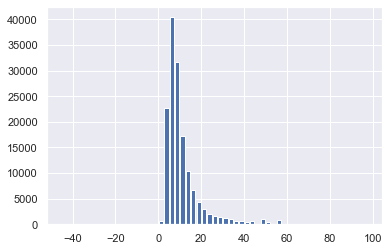

In [12]:
minimo = df.fare_amount.min()

bins = np.arange(minimo,100,2.5)

plt.figure()
df.fare_amount.hist(bins=bins, rwidth=.8);


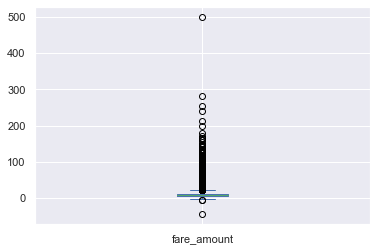

In [13]:
df['fare_amount'].plot(kind = 'box');

In [14]:
top = df['fare_amount'].quantile(0.975)
top

42.83

In [15]:
down =df['fare_amount'].quantile(0.025)
down

3.7

### Feature distancia

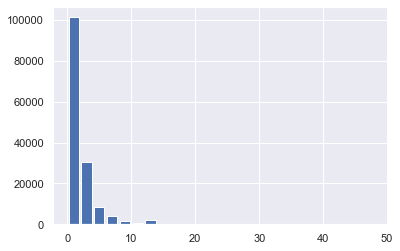

In [16]:
minimo = df.distancia.min()

bins = np.arange(minimo,50,2)

plt.figure()
df.distancia.hist(bins=bins, rwidth=.8);


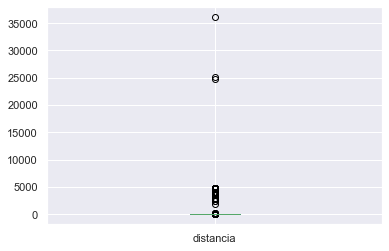

In [17]:
df['distancia'].plot(kind = 'box');

In [18]:
top1 = df['distancia'].quantile(0.975)
top1

9.586651309287273

In [19]:
down1 = df['distancia'].quantile(0.025)
down1

0.0

### 3.6 Com base na detecção de outliers, estão sendo aplicados limites razoáveis às tarifas e distâncias.

In [20]:
df = df[(df['distancia'] > 0) & (df['distancia'] < 10)]
df = df[(df['fare_amount'] > 3) & (df['fare_amount'] < 45)]

corr_matrix2 = df.corr()
corr_matrix2['fare_amount'].sort_values(ascending=False)

fare_amount        1.000000
distancia          0.876473
passenger_count    0.014128
dia                0.008400
hora              -0.024811
Name: fare_amount, dtype: float64

- Existe uma forte correlação entre a distância percorrida e o valor da tarifa.
- A correlação entre o dia da semana, a hora do dia, número de passageiros  e o valor da tarifa ainda é fraca, mas vamos deixar essas colunas.

In [21]:
df.shape

(139967, 5)

- Isso deixa 139967 linhas no conjunto de dados.

## 4. Treinamento dos modelos

### 4.1 Divisão em treino e teste

In [22]:
X = df.drop(['fare_amount'], axis=1)
y = df['fare_amount']
 
from sklearn.model_selection import train_test_split

X_tr, X_ts, y_tr, y_ts = train_test_split(X,y, test_size=0.30, random_state=7)

X_tr

,passenger_count,dia,hora,distancia
141359,1,6.0,8.0,1.482355
22525,1,3.0,9.0,1.312098
135668,2,5.0,11.0,1.467270
120224,1,2.0,10.0,1.040250
145889,1,2.0,11.0,0.005553
...,...,...,...,...
71223,1,6.0,19.0,3.590887
57286,1,3.0,16.0,1.224888
11497,1,2.0,9.0,1.398217
53242,2,6.0,2.0,1.551872


- Tentaremos dois algoritmos de regressão diferentes para determinar qual deles produz os resultados mais precisos.

### 4.2 Regressão Linear

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

lr = LinearRegression()

# Ajuste do modelo nos dados de TREINO
lr.fit(X_tr, y_tr)

# Utilizando o modelo para predizer os dados de TESTE
y_pred_lr = lr.predict(X_ts)

# Métricas para Avaliação RMSE e MAE

RMSE_lr = mean_squared_error(y_ts, y_pred_lr)**0.5

MAE_lr = mean_absolute_error(y_ts, y_pred_lr)

print(f"O valor do RMSE foi de {RMSE_lr:.4f} dólares")
print(f"O valor do MAE foi de {MAE_lr:.4f} dólares")


O valor do RMSE foi de 3.1741 dólares
O valor do MAE foi de 2.0411 dólares


- O modelo está  errando mais ou menos 3.17 dólares e 2.04 dólares em termos absolutos.

### Histograma do modelo

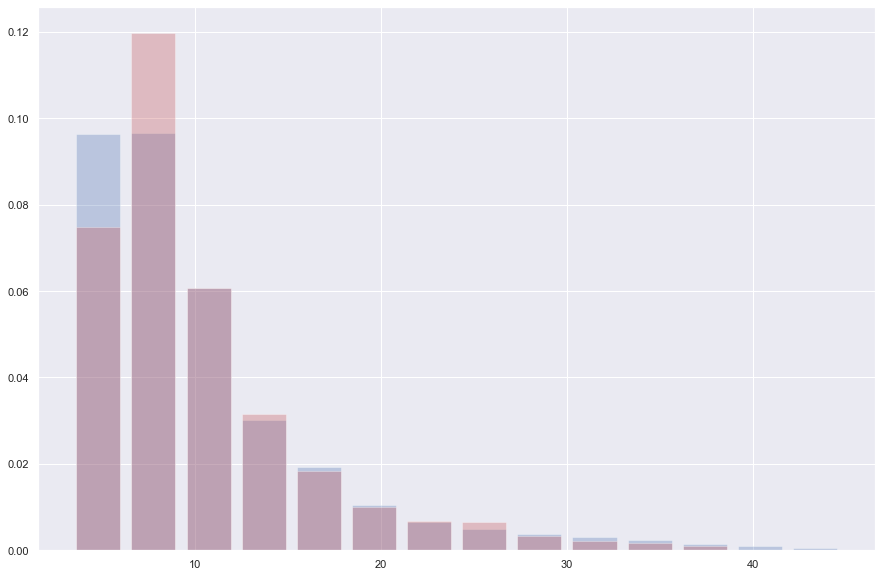

In [24]:
plt.figure(figsize=(15,10))

m1 = y_ts.min()
M1 = y_ts.max()

plt.hist(y_ts, bins=np.linspace(m1,M1,15), rwidth=.8, density=True, alpha=.3, color='b')
plt.hist(lr.predict(X_ts), bins=np.linspace(m1,M1,15), rwidth=.8, density=True, alpha=.3, color='r');

- O modelo está prevendo bem, porém tem certa dificuldade para predizer tarifas menores.

### 4.3 Árvores de Decisão

In [25]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Definição dos parâmetros de VALIDAÇÃO CRUZADA

params = {
    'max_leaf_nodes':[75,100,125],
    'min_samples_leaf': [8,9,10],
}

grid = GridSearchCV(
    DecisionTreeRegressor(criterion='squared_error', random_state=7),
    params,
    cv=10,
    scoring='neg_mean_absolute_error',
    n_jobs=5,
    verbose=0
)


grid.fit(X_tr, y_tr)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=7), n_jobs=5,
             param_grid={'max_leaf_nodes': [75, 100, 125],
                         'min_samples_leaf': [8, 9, 10]},
             scoring='neg_mean_absolute_error')

In [26]:
# Quais foram os melhores parâmetros?
grid.best_params_

{'max_leaf_nodes': 100, 'min_samples_leaf': 9}

In [27]:
# Utilizando o modelo ajustado para predizer os dados de TESTE

y_pred_tree = grid.predict(X_ts)

# Métricas para Avaliação RMSE e MAE

RMSE_tree = mean_squared_error(y_ts, y_pred_tree)**0.5

MAE_tree = mean_absolute_error(y_ts, y_pred_tree)

print(f"O valor do RMSE foi de {RMSE_tree:.4f} dólares")
print(f"O valor do MAE foi de {MAE_tree:.4f} dólares")

O valor do RMSE foi de 3.0353 dólares
O valor do MAE foi de 1.9599 dólares


- O modelo está  errando mais ou menos 3.03 dólares e 1.95 dólares em termos absolutos. No entanto, em comparação com o modelo anterior, o desempenho deste modelo é um pouco melhor.

### Histograma do modelo

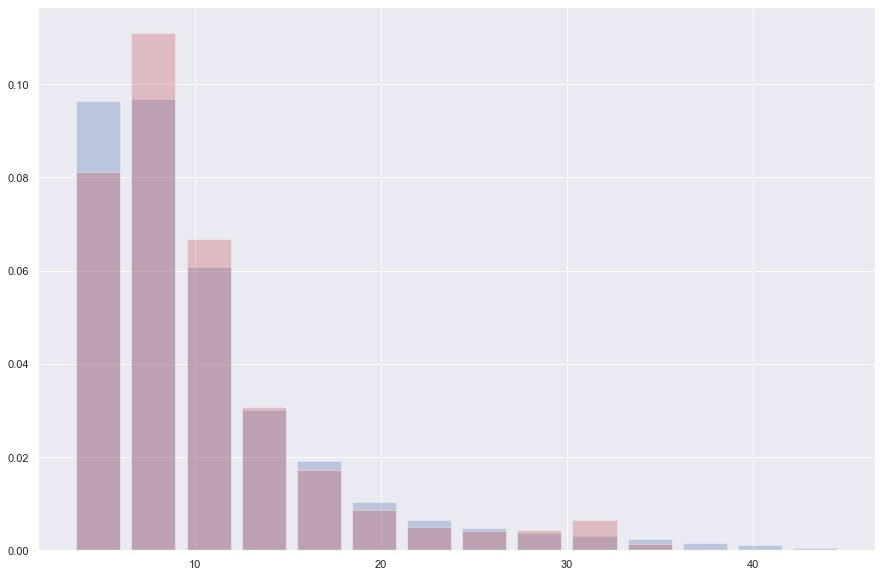

In [28]:
plt.figure(figsize=(15,10))

m = y_ts.min()
M = y_ts.max()

plt.hist(y_ts, bins=np.linspace(m,M,15), rwidth=.8, density=True, alpha=.3, color='b')
plt.hist(grid.predict(X_ts), bins=np.linspace(m,M,15), rwidth=.8, density=True, alpha=.3, color='r');

- O modelo atual demonstra um desempenho ligeiramente superior em relação ao modelo anterior, de acordo com as métricas de RMSE  e MAE.

### Verificar a IMPORTÂNCIA DE VARIÁVEIS

In [29]:
importancias = grid.best_estimator_.feature_importances_
ordem = np.argsort(importancias)[::-1]
colunas = X.columns

for col,imp in zip(colunas[ordem],importancias[ordem]):
    print(f'{col:30s},{imp:.4f}')

distancia                     ,0.9844
hora                          ,0.0135
dia                           ,0.0019
passenger_count               ,0.0001


- A variável mais importante para prever a tarifa neste modelo foi a distância.
- Podemos melhorar o modelo de árvore de decisão usando a importância das variáveis.Podemos eliminar a variável passenger_count.

###  Fazendo um modelo melhor  (ou no mínimo mais simples)

In [30]:
colunas_selecionadas = [
    'dia',
    'hora',
    'distancia',
    
]

grid.fit(X_tr[colunas_selecionadas],y_tr)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=7), n_jobs=5,
             param_grid={'max_leaf_nodes': [75, 100, 125],
                         'min_samples_leaf': [8, 9, 10]},
             scoring='neg_mean_absolute_error')

In [31]:
# Utilizando o modelo ajustado para predizer os dados de TESTE

y_pred_tree1 = grid.predict(X_ts[colunas_selecionadas])

# Métricas para Avaliação RMSE e MAE

RMSE_tree1 = mean_squared_error(y_ts, y_pred_tree1)**0.5

MAE_tree1 = mean_absolute_error(y_ts, y_pred_tree1)

print(f"O valor do RMSE foi de {RMSE_tree1:.4f} dólares")
print(f"O valor do MAE foi de {MAE_tree1:.4f} dólares")

O valor do RMSE foi de 3.0341 dólares
O valor do MAE foi de 1.9587 dólares


- Houve uma pequena melhoria na métrica RMSE em relação ao modelo anterior.

- O modelo de árvore de decisão mais simple (sem a variável passenger_count )  é escolhido como o modelo final para este projeto.

### 4.4 Utilizando o modelo para prever os valores das tarifas

In [32]:
# Prevendo o valor da tarifa para uma viagem de 3 milhas feita às 16:00 no dia sábado

grid.predict(pd.DataFrame({ 'dia': [5], 'hora': [16], 'distancia': [3.0] }))

array([13.70846918])

In [33]:
# Prevendo o valor da tarifa para uma viagem de 8 milhas feita às 11:00 a.m. na segunda-feira

grid.predict(pd.DataFrame({ 'dia': [0], 'hora': [11], 'distancia': [8.0] }))

array([32.09864729])

## 5. Conclusão

- Com base na hora do dia, dia da semana e a distância percorrida fornecidos, o modelo pode fazer uma previsão estimada do valor da tarifa. 


- O modelo está errando mais ou menos 3.03 dólares (RMSE) e 1.95 dólares em termos absolutos (MAE).


- A variável mais importante para prever a tarifa foi a distância.


- Podemos explorar outros algoritmos de aprendizado, como Random Forest e Gradient Boosting, para melhorar a previsão do modelo. 